In [1]:
! nvidia-smi

Tue Mar  5 05:27:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.10              Driver Version: 535.86.10    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A5500               On  | 00000000:51:00.0 Off |                  Off |
| 30%   58C    P2              70W / 230W |  24024MiB / 24564MiB |     24%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import warnings

warnings.filterwarnings('ignore')

# from tensorflow.compat.v1.keras.backend import get_session
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

tf.compat.v1.disable_v2_behavior()  # breaks

2024-03-05 05:27:41.633936: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-05 05:27:41.868664: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-05 05:27:41.869890: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-05 05:27:42.806673: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  0
Instructions for updating:
non-resource variables are not supported in the long term


2024-03-05 05:27:43.774852: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [100]:
import numpy

# numpy = reload(numpy)
print(numpy.__version__)

import numpy as np

np.int = int  # Fix deprecated for LUX

1.24.1


In [103]:
import dill
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import shap

from collections import deque
from joblib import load
from keras.utils import to_categorical
from lime.lime_tabular import LimeTabularExplainer
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
from typing import Any, Optional, Tuple

DATA_DIRECTORY = "shared/metropt/"

In [5]:
# @formatter:off
ls shared
# @formatter:on

 comparison.svg                                        shared-metro.zip
 convlstm-metropt.ipynb                                summaryMultivariate.csv
 dtw-vs-no-dtw/                                        summaryUnivariate.csv
 gpu_users.sh*                                         szymon-env-3.8.yml
'Keras LSTM for IMDB Sentiment Classification.ipynb'   tsproto/
 metropt/                                              Untitled1.ipynb
 proto.tar.gz                                          Untitled2.ipynb
 ProtoTSNet/                                           Untitled.ipynb
 README.txt                                            windowshap/


In [6]:
%cd shared
from tsproto.windowshap import SlidingWindowSHAP
%cd ..

/home/jovyan/shared
/home/jovyan


In [93]:
def exponential_smoothing(series, alpha):
    """
    Perform exponential smoothing on a pandas Series.

    Parameters:
    series (pd.Series): Input time series as a pandas Series.
    alpha (float): Smoothing parameter (0 < alpha < 1).

    Returns:
    pd.Series: Exponentially smoothed time series.
    """
    smoothed_values = [series.iloc[0]]  # Initialize with the first value
    for t in range(1, len(series)):
        smoothed_value = alpha * series.iloc[t] + (1 - alpha) * smoothed_values[-1]
        smoothed_values.append(smoothed_value)

    return pd.Series(smoothed_values, index=series.index)


def save_to_pickle(obj, filename, directory=DATA_DIRECTORY):
    """
    Save an object to a pickle file.

    Parameters:
    - obj: Object to save
    - filename: Name of the pickle file
    - directory: Directory to save the pickle file (default is DATA_DIRECTORY)

    Returns:
    - None
    """
    filepath = os.path.join(directory, filename)

    # Check if the object is a pandas DataFrame
    if isinstance(obj, pd.DataFrame):
        obj.to_pickle(filepath)
    else:
        with open(filepath, 'wb') as f:
            pickle.dump(obj, f)

    print(f"Saved to {filepath}")


def load_from_pickle(filename, directory=DATA_DIRECTORY):
    """
    Load an object from a pickle file using pandas, pickle, or joblib as a fallback.

    Parameters:
    - filename: Name of the pickle file
    - directory: Directory where the pickle file is located (default is DATA_DIRECTORY)

    Returns:
    - Object loaded from the pickle file
    """
    filepath = os.path.join(directory, filename)

    try:
        import pandas as pd
        obj = pd.read_pickle(filepath)
    except Exception as e:  # Catch any exception from pandas
        print(f"Failed to load pickle with pandas due to: {e}")
        try:
            with open(filepath, 'rb') as f:
                obj = pickle.load(f)
        except Exception as e:  # Catch any exception from standard pickle
            print(f"Failed to load pickle with standard pickle due to: {e}")
            try:
                obj = load(filepath)  # Try with joblib
            except Exception as e:
                print(f"Failed to load pickle with joblib due to: {e}")
                try:
                    obj = dill.load(filepath)  # Try with joblib
                except Exception as e:
                    print(f"Failed to load pickle with dill due to: {e}")

                    raise e  # Re-raise the exception if all methods fail

    return obj


def calculate_threshold_err_cumalert(df: pd.DataFrame) -> None:
    df_cp = df.copy()
    df_cp.loc[:, "threshold_err"] = 0
    df_cp.loc[:, "alert"] = 0
    df_cp.loc[:, "cumalert"] = 0
    bufflen = int(2 * 24 * 7)  #sampels_per_hour * 24 * days
    buffer = deque(maxlen=bufflen)
    abufflen = int(2 * 4)  #samples_per_hour * monitoring_hours
    alertbuf = deque(maxlen=abufflen)
    for i, r in df_cp.iterrows():
        if len(buffer) < bufflen:
            buffer.append(r['err'])
            continue
        avg = np.mean(buffer)
        sigma = np.std(buffer)
        if r['err'] > avg + 3 * sigma:
            df_cp.loc[i, 'alert'] = 1
            alertbuf.append(1)
        else:
            alertbuf.append(0)
            buffer.append(r['err'])
        df_cp.loc[i, 'cumalert'] = sum(alertbuf)

        if sum(alertbuf) >= 0.75 * abufflen:
            df_cp.loc[i, 'alert'] = 40
        else:
            df_cp.loc[i, 'alert'] = 0
        df_cp.loc[i, "threshold_err"] = avg + 3 * sigma

    return df_cp


def calculate_shap_values(fXtrain: np.ndarray,
                          fXtest: np.ndarray,
                          ftrainy: np.ndarray,
                          ftesty: np.ndarray,
                          model_classifier: Any,
                          stride: int,
                          window_len: int,
                          shap_version: str = 'deep',
                          bg_size: int = 1000,
                          absshap: bool = True,
                          ) -> Tuple[
    Optional[np.ndarray], Optional[np.ndarray], Optional[np.ndarray], Optional[np.ndarray]]:
    """
    Calculates SHAP values for training and testing datasets using either DeepExplainer or SlidingWindowSHAP.
    
    :param fXtrain: Training features.
    :param fXtest: Testing features.
    :param ftrainy: Training labels.
    :param ftesty: Testing labels.
    :param model_classifier: The model to explain.
    :param stride: Stride for sliding window SHAP.
    :param window_len: Window length for sliding window SHAP.
    :param shap_version: 'deep' for DeepExplainer, 'window' for SlidingWindowSHAP.
    :param bg_size: Background dataset size for explanations.
    :param absshap: Whether to use absolute SHAP values, only for DeepExplainer.
    :return: Tuple of SHAP values for training and testing datasets.
    """
    sv_ts, sv_tr, shap_values_ts, shap_values_tr = None, None, None, None
    if shap_version == 'window':
        # Handle window-based SHAP
        indexes = np.arange(len(fXtrain))
        np.random.shuffle(indexes)
        maxid = min(bg_size, len(fXtrain))
        background_data = fXtrain[indexes[:maxid]]

        sv_ts = np.zeros((len(fXtest), fXtest.shape[1], fXtest.shape[2]))
        sv_tr = np.zeros((len(fXtrain), fXtrain.shape[1], fXtrain.shape[2]))

        # Calculate for test data
        for i in range(len(fXtest)):
            gtw = SlidingWindowSHAP(model_classifier, stride, window_len, background_data, fXtest[i:i + 1],
                                    model_type='lstm')
            sv_ts[i, :, :] = gtw.shap_values(num_output=ftesty.shape[1])
        # Calculate for train data
        for i in range(len(fXtrain)):
            gtw = SlidingWindowSHAP(model_classifier, stride, window_len, background_data, fXtrain[i:i + 1],
                                    model_type='lstm')
            sv_tr[i, :, :] = gtw.shap_values(num_output=ftrainy.shape[1])

    elif shap_version == 'deep':
        # Handle deep SHAP
        indexes = np.arange(len(fXtrain))
        np.random.shuffle(indexes)
        maxid = min(bg_size, len(fXtrain))
        background_data = fXtrain[indexes[:maxid]]

        explainer = shap.DeepExplainer(model_classifier, background_data)
        shap_values_ts = explainer.shap_values(fXtest, check_additivity=False)
        shap_values_tr = explainer.shap_values(fXtrain, check_additivity=False)

        if absshap:
            sv_ts = abs(np.array(shap_values_ts)).mean(axis=0)
            sv_tr = abs(np.array(shap_values_tr)).mean(axis=0)
        else:
            indexer_ts = np.argmax(model_classifier.predict(fXtest), axis=1)
            sv_ts = [shap_values_ts[indexer_ts[i]][i, :] for i in range(len(fXtest))]
            sv_ts = np.concatenate(sv_ts).reshape((-1, 30, 16))

            indexer_tr = np.argmax(model_classifier.predict(fXtrain), axis=1)
            sv_tr = [shap_values_tr[indexer_tr[i]][i, :] for i in range(len(fXtrain))]
            sv_tr = np.concatenate(sv_tr).reshape((-1, 30, 16))

    return sv_ts, sv_tr, shap_values_ts, shap_values_tr



# data

In [8]:
# @formatter:off
ls shared/metropt
# @formatter:on

dataset_train.csv                 model_lstmconv_encoder_v3_fun.h5
model_classifier_v3_fun.h5        model_lstmconv_encoder_v4_fun.h5
model_classifier_v7_fun.h5        model_lstmconv_encoder_v5_seq.h5
model_classifier_v8_fun.h5        model_lstmconv_encoder_v6_fun.h5
model_classifier_v8_seq.h5        model_lstmconv_encoder_v7_seq.h5
model_classifier_v9_seq.h5        model_lstmconv_encoder_v8_fun.h5
model_lstmconv_ae_fun.h5          model_lstmconv_encoder_v9_seq.h5
model_lstmconv_ae_v2_fun.h5       shap_values_tr_v8_fun.pkl
model_lstmconv_ae_v3_fun.h5       shap_values_tr_v9_seq.pkl
model_lstmconv_ae_v4_fun.h5       shap_values_ts_v8_fun.pkl
model_lstmconv_ae_v5_seq.h5       shap_values_ts_v9_seq.pkl
model_lstmconv_ae_v6_fun.h5       sv_tr_absshap_true_v8_fun.pkl
model_lstmconv_ae_v7_seq.h5       sv_tr_absshap_true_v9_seq.pkl
model_lstmconv_ae_v8_fun.h5       sv_ts_absshap_true_v8_fun.pkl
model_lstmconv_ae_v9_seq.h5       sv_ts_absshap_true_v9_seq.pkl
model_lstmconv_encoder_v2_fun.h5


In [9]:
metro_o = pd.read_csv('shared/metropt/dataset_train.csv')
features_o = [f for f in metro_o.columns if f not in ['gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality']]
metro_o = metro_o[features_o]

print(", ".join(features_o))

timestamp, TP2, TP3, H1, DV_pressure, Reservoirs, Oil_temperature, Flowmeter, Motor_current, COMP, DV_eletric, Towers, MPG, LPS, Pressure_switch, Oil_level, Caudal_impulses


In [10]:
resampling = '60s'

metro_o['timestamp'] = metro_o['timestamp'].astype('datetime64[ns]')
if resampling is not None:
    metro = metro_o.set_index('timestamp').resample(resampling).mean().reset_index().dropna()
else:
    metro = metro_o

# model

In [11]:
seq_ae_model_path = "shared/metropt/model_lstmconv_ae_v9_seq.h5"
fun_ae_model_path = "shared/metropt/model_lstmconv_ae_v8_fun.h5"
seq_ae_model = load_model(seq_ae_model_path)
fun_ae_model = load_model(fun_ae_model_path)

seq_e_model_path = "shared/metropt/model_lstmconv_encoder_v9_seq.h5"
fun_e_model_path = "shared/metropt/model_lstmconv_encoder_v8_fun.h5"
seq_e_model = load_model(seq_e_model_path)
fun_e_model = load_model(fun_e_model_path)

seq_classifier_model_path = "shared/metropt/model_classifier_v9_seq.h5"
fun_classifier_model_path = "shared/metropt/model_classifier_v8_fun.h5"
seq_classifier_model = load_model(seq_classifier_model_path)
fun_classifier_model = load_model(fun_classifier_model_path)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2024-03-05 05:46:52.344671: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2024-03-05 05:46:52.384104: W tensorflow/c/c_api.cc:304] Operation '{name:'time_distributed_10/bias/Assign' id:721 op device:{requested: '', assigned: ''} def:{{{node time_distributed_10/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](time_distributed_10/bias, time_distributed_10/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-03-05 05:46:52.559207: W tensorflow/c/c_api.cc:304] Operation '{name:'time_distributed_10/kernel/v/Assign' id:1073 op device:{requested: '', assigned: ''} def:{{{node time_distributed_10/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, val

2024-03-05 05:46:53.550337: W tensorflow/c/c_api.cc:304] Operation '{name:'conv_lstm1d_6_1/recurrent_kernel/Assign' id:2432 op device:{requested: '', assigned: ''} def:{{{node conv_lstm1d_6_1/recurrent_kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv_lstm1d_6_1/recurrent_kernel, conv_lstm1d_6_1/recurrent_kernel/Initializer/mul_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-03-05 05:46:53.884146: W tensorflow/c/c_api.cc:304] Operation '{name:'conv_lstm1d_2/recurrent_kernel/Assign' id:3088 op device:{requested: '', assigned: ''} def:{{{node conv_lstm1d_2/recurrent_kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv_lstm1d_2/recurrent_kernel, conv_lstm1d_2/recurrent_kernel/Initializer/mul_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-03-05 05:46:54.270909: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_3/kernel/Assign' id:4364 op device:{requested: '', assigned: ''} def:{{{node dense_3/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_3/kernel, dense_3/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a 

In [12]:
ae_model_compilation_params = {'loss': 'mse', 'optimizer': 'adam', 'metrics': ['mse']}
e_model_compilation_params = {'loss': 'categorical_crossentropy', 'optimizer': 'adam', 'metrics': ['accuracy']}

seq_ae_model.compile(**ae_model_compilation_params)
fun_ae_model.compile(**ae_model_compilation_params)

seq_e_model.compile(**e_model_compilation_params)
fun_e_model.compile(**e_model_compilation_params)
# the same params as for encoder
seq_classifier_model.compile(**e_model_compilation_params)
fun_classifier_model.compile(**e_model_compilation_params)

# test pretrained models

## select models

In [13]:
model_lstmconv_ae, encoder, model_classifier = seq_ae_model, seq_e_model, seq_classifier_model

## prepare test data

In [123]:
mms = MinMaxScaler()
healthy = metro[metro['timestamp'] < '2022-02-01']
features = [f for f in healthy if f not in ['timestamp', 'gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality']]
healthy.loc[:, features] = mms.fit_transform(healthy[features])

print(", ".join(features))

TP2, TP3, H1, DV_pressure, Reservoirs, Oil_temperature, Flowmeter, Motor_current, COMP, DV_eletric, Towers, MPG, LPS, Pressure_switch, Oil_level, Caudal_impulses


In [ ]:
window_len = 30
stride = window_len  #for test data we do not need overlapping

realdata = metro[metro['timestamp'] >= '2022-02-01']
realdata.loc[:, features] = mms.transform(realdata[features])

In [ ]:
# Improve speed as it is very slow:
start = 0
X = list()
timestamps = list()
while start + window_len <= realdata.shape[0]:
    X.append(realdata.iloc[start:start + window_len, 1:].T.values)
    timestamps.append(realdata.iloc[start].timestamp)
    start = start + stride
    break

In [36]:
pd.DataFrame(X[0])

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.001505,0.001547,0.001550,0.001550,0.794301,0.954501,0.097562,0.001351,0.001540,0.001569,...,0.001592,0.001585,0.001547,0.001563,0.001605,0.001556,0.001556,0.008569,0.848202,0.969697
1,0.851935,0.800875,0.774096,0.760116,0.782274,0.914507,0.980593,0.961309,0.920864,0.874941,...,0.892590,0.883405,0.874089,0.853113,0.803409,0.785795,0.766229,0.755200,0.805218,0.933155
2,0.876047,0.833233,0.810814,0.797636,0.000647,0.001193,0.893696,0.968117,0.933987,0.895445,...,0.910222,0.902559,0.894694,0.877104,0.835421,0.820627,0.804159,0.751762,0.000706,0.001291
3,0.017623,0.018288,0.017789,0.014630,0.044389,0.053699,0.576060,0.017290,0.015960,0.018121,...,0.018953,0.019950,0.020615,0.018454,0.017456,0.016958,0.014464,0.016126,0.049210,0.057855
4,0.629811,0.629180,0.629022,0.627997,0.626577,0.628391,0.631151,0.632098,0.632808,0.632334,...,0.635252,0.635331,0.634543,0.632256,0.632019,0.630678,0.627839,0.625710,0.626498,0.628943
5,0.836112,0.847708,0.841591,0.802930,0.797147,0.877959,0.909022,0.894670,0.873518,0.854739,...,0.853034,0.846075,0.852627,0.836345,0.799708,0.771692,0.753588,0.735433,0.754452,0.875535
6,0.011144,0.009419,0.010145,0.009975,0.605606,0.715031,0.084147,0.012398,0.011267,0.011276,...,0.011804,0.011748,0.011710,0.010145,0.009966,0.009541,0.010183,0.010126,0.629639,0.713456
7,0.627997,0.619613,0.218732,0.022748,0.910382,0.960741,0.664005,0.623703,0.618434,0.627326,...,0.623703,0.615827,0.621292,0.002309,0.001632,0.001598,0.001605,0.056860,0.925078,0.964269
8,1.000000,1.000000,1.000000,0.983333,0.000000,0.000000,0.933333,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.933333,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.016667,1.000000,1.000000,0.066667,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,1.000000,1.000000


In [32]:
number_of_windows = (realdata.shape[0] - window_len) // stride + 1
realX = np.zeros((number_of_windows, window_len, len(features)))
timestamps = []

for i in range(number_of_windows):
    window_start = i * stride
    window_end = window_start + window_len
    realX[i] = realdata.iloc[window_start:window_end][features].values
    timestamps.append(realdata.iloc[window_start].timestamp)

# Przekształcenie osi
realX = np.moveaxis(realX, 1, -1)
# Sprawdź aktualny kształt danych realX, oczekiwane (liczba_okien, 30, 16)
print(realX.shape)

# Zmiana kształtu danych
transformedRealX = np.transpose(realX, (0, 2, 1))

# Sprawdzenie nowego kształtu
print(transformedRealX.shape)

(4753, 16, 30)
(4753, 30, 16)


In [33]:
realX[0]

array([[1.50485702e-03, 1.54665861e-03, 1.54987411e-03, 1.54987411e-03,
        7.94300836e-01, 9.54500584e-01, 9.75616815e-02, 1.35051271e-03,
        1.54022759e-03, 1.56916715e-03, 1.54022759e-03, 1.54987411e-03,
        1.53701209e-03, 4.97631779e-02, 8.64945513e-01, 9.62828745e-01,
        9.45005193e-02, 1.35051271e-03, 1.56273614e-03, 1.58524468e-03,
        1.59167570e-03, 1.58524468e-03, 1.54665861e-03, 1.56273614e-03,
        1.60453772e-03, 1.55630513e-03, 1.55630513e-03, 8.56932471e-03,
        8.48202371e-01, 9.69697067e-01],
       [8.51934922e-01, 8.00875460e-01, 7.74096456e-01, 7.60116212e-01,
        7.82273872e-01, 9.14507070e-01, 9.80592679e-01, 9.61309316e-01,
        9.20863839e-01, 8.74940926e-01, 8.41243463e-01, 8.23494093e-01,
        7.88243269e-01, 7.51307379e-01, 8.04714313e-01, 9.24210730e-01,
        9.74150688e-01, 9.33255859e-01, 9.11291885e-01, 9.01971722e-01,
        8.92589580e-01, 8.83404997e-01, 8.74088708e-01, 8.53112531e-01,
        8.03408871e-01,

In [39]:
# Chcek improved method for first observation
# Assuming X[0] and realX[0] are available as NumPy arrays or compatible formats for creating DataFrames.

# Convert X[0] to a DataFrame if it's not already one
df1 = pd.DataFrame(X[0]) if not isinstance(X[0], pd.DataFrame) else X[0]

# realX[0] is assumed to be a DataFrame based on your description
df2 = pd.DataFrame(realX[0])

# Check if they have the same shape
same_shape = df1.shape == df2.shape

# Check if they have the same content
same_content = df1.equals(df2)

# Output results
print(f"Same shape: {same_shape}")
print(f"Same content: {same_content}")

# If you want to be more detailed in comparing content, especially if they do not match, you can compare element-wise
if not same_content:
    comparison = df1 == df2
    print("Differences found at:")
    print(comparison[comparison == False])

del df1, df2

Same shape: True
Same content: True


# test autoencoder

In [40]:
reconstructedRealX = model_lstmconv_ae.predict(transformedRealX)
reconstructedRealX

array([[[-3.4288112e-03,  8.4013790e-01,  8.6726308e-01, ...,
          2.8948305e-04, -5.7278905e-04,  4.9267551e-03],
        [ 2.4156291e-03,  8.1222790e-01,  8.3828568e-01, ...,
          6.0743478e-05,  1.8655083e-03,  7.4178874e-03],
        [-3.8305614e-03,  7.8019547e-01,  8.1421018e-01, ...,
         -1.0631763e-04,  2.9514215e-03,  6.6735130e-03],
        ...,
        [ 8.5978732e-03,  7.5311929e-01,  7.6585793e-01, ...,
         -1.2348112e-04,  1.9666620e-03,  4.7436198e-03],
        [ 8.1336623e-01,  7.9437745e-01,  7.2286502e-03, ...,
         -7.5664953e-05,  1.6945952e-03,  6.3963099e-03],
        [ 9.3235958e-01,  9.1912937e-01,  2.3066580e-02, ...,
         -1.0662450e-04,  1.9144451e-03,  3.5948791e-03]],

       [[ 1.0287773e-01,  9.7575092e-01,  8.8616335e-01, ...,
         -1.0349386e-04,  8.1592653e-04,  1.6444456e-03],
        [ 7.3775835e-04,  9.3143630e-01,  9.4181478e-01, ...,
          2.3342960e-05,  1.1834556e-03,  8.0721695e-03],
        [-1.5188418e-03, 

In [41]:
print("transformedRealX shape:", transformedRealX.shape)
print("reconstructedRealX shape:", reconstructedRealX.shape)

if transformedRealX.shape == reconstructedRealX.shape:
    mse = mean_squared_error(transformedRealX.reshape(-1), reconstructedRealX.reshape(-1))
    print("MSE:", mse)
else:
    print("Kształty danych nie są zgodne, nie można obliczyć MSE.")

transformedRealX shape: (4753, 30, 16)
reconstructedRealX shape: (4753, 30, 16)
MSE: 0.0006688068118780912


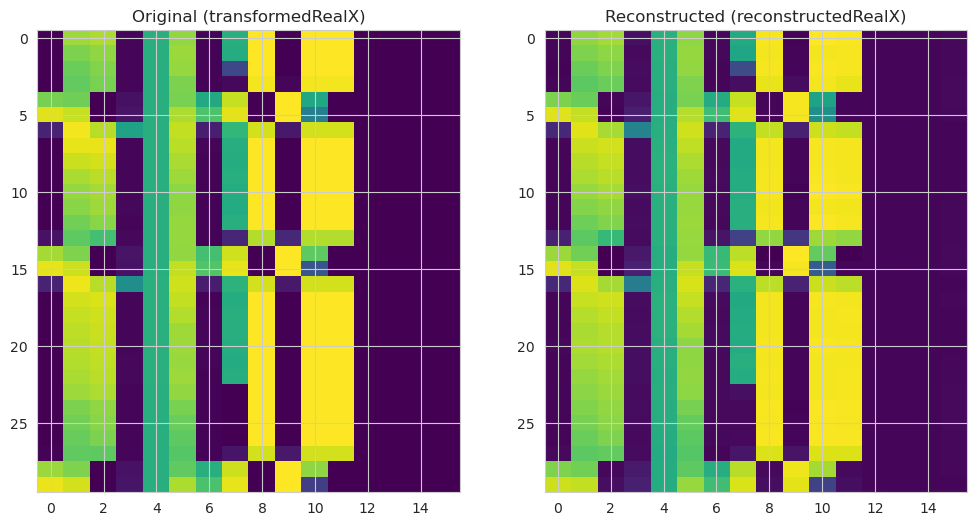

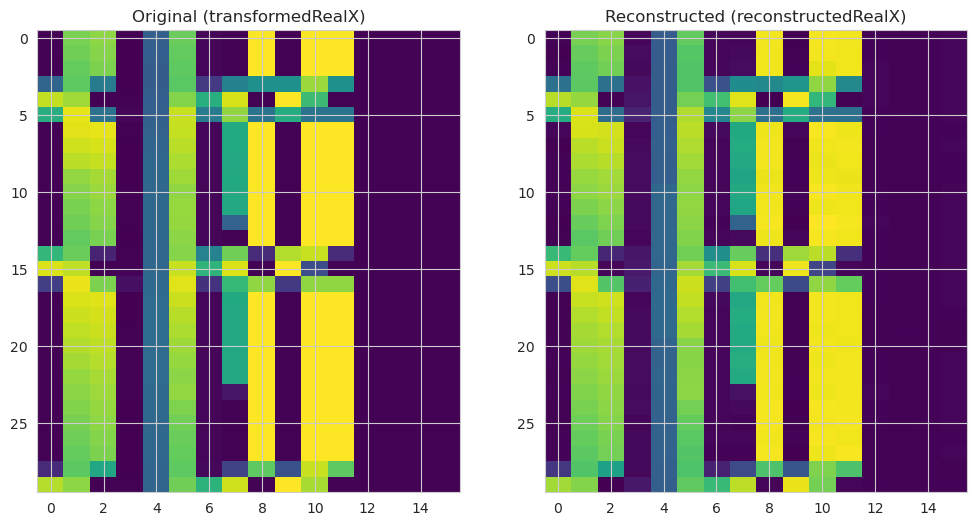

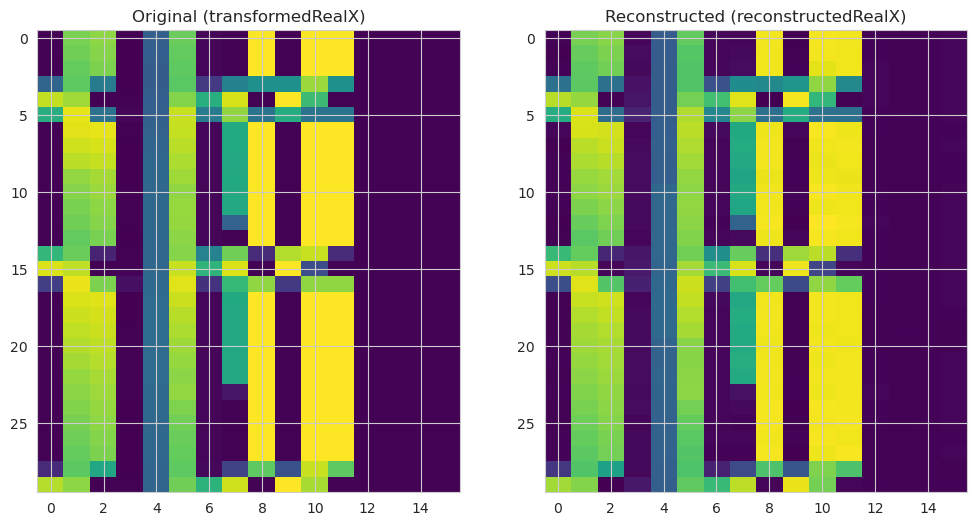

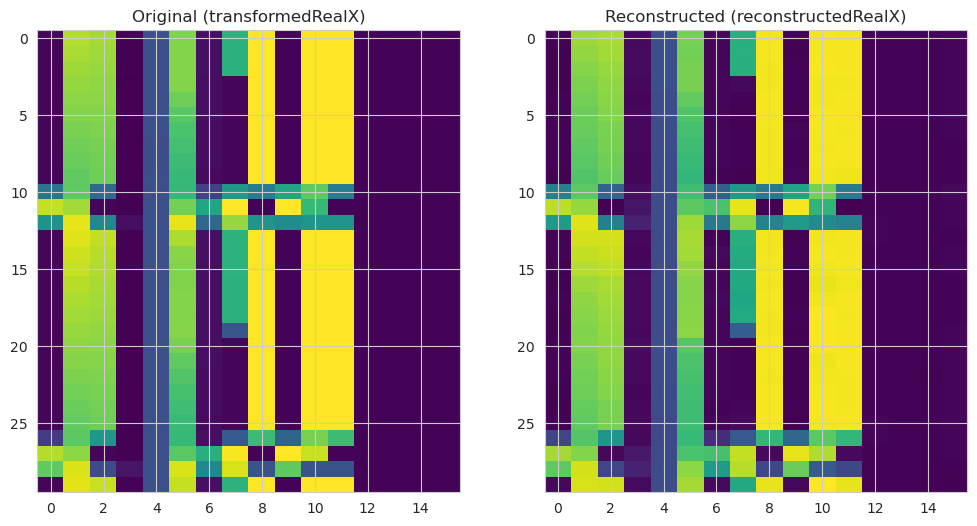

In [42]:
# Próbki do wizualizacji
sample_indexs = [0, -4753 // 2, 4753 // 2, 4753 - 1, ]

for sample_index in sample_indexs:
    # Upewnij się, że dane są w odpowiednim kształcie i mają ten sam rozmiar
    if transformedRealX.shape == reconstructedRealX.shape:
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(transformedRealX[sample_index], aspect='auto', cmap='viridis')
        axes[0].set_title('Original (transformedRealX)')
        axes[1].imshow(reconstructedRealX[sample_index], aspect='auto', cmap='viridis')
        axes[1].set_title('Reconstructed (reconstructedRealX)')
        plt.show()
    else:
        print("Kształty danych nie są zgodne, nie można zwizualizować.")


## test classifier model

In [43]:
recerr = (reconstructedRealX - transformedRealX)

recerr_agg = np.mean(np.mean(np.abs(recerr), axis=1), axis=1)
recerr_agg_idx = np.argmax(np.mean(np.abs(recerr), axis=1), axis=1)

recerr_agg_df = pd.DataFrame({'timestamp': timestamps, 'erro': recerr_agg})
recerr_agg_df['err'] = recerr_agg_df['erro']
recerr_agg_df['err'] = exponential_smoothing(recerr_agg_df['erro'], alpha=0.5)

rolling_buffer = '7d'

err = recerr_agg_df.set_index('timestamp')
# err.loc[:, "threshold_err"] = (err.rolling(rolling_buffer).mean() + 3 * err.rolling(rolling_buffer).std())['err']
# err['alert'] = (err['err'] > err['threshold_err']).astype(int)  #/2
err_2 = calculate_threshold_err_cumalert(err)

In [44]:
err_2.describe()

,erro,err,threshold_err,alert,cumalert
count,4753.000000,4753.000000,4753.000000,4753.000000,4753.000000
mean,0.010257,0.010256,0.012093,1.329687,0.543446
std,0.011977,0.011019,0.003577,7.171486,1.566785
min,0.003428,0.004265,0.000000,0.000000,0.000000
25%,0.007087,0.007325,0.011610,0.000000,0.000000
50%,0.009193,0.009242,0.012843,0.000000,0.000000
75%,0.010821,0.010848,0.014193,0.000000,0.000000
max,0.255131,0.231518,0.015415,40.000000,8.000000


(array([19024., 19038., 19052., 19066., 19083., 19097., 19113., 19127.,
        19144.]),
 [Text(19024.0, 0, '2022-02-01'),
  Text(19038.0, 0, '2022-02-15'),
  Text(19052.0, 0, '2022-03-01'),
  Text(19066.0, 0, '2022-03-15'),
  Text(19083.0, 0, '2022-04-01'),
  Text(19097.0, 0, '2022-04-15'),
  Text(19113.0, 0, '2022-05-01'),
  Text(19127.0, 0, '2022-05-15'),
  Text(19144.0, 0, '2022-06-01')])

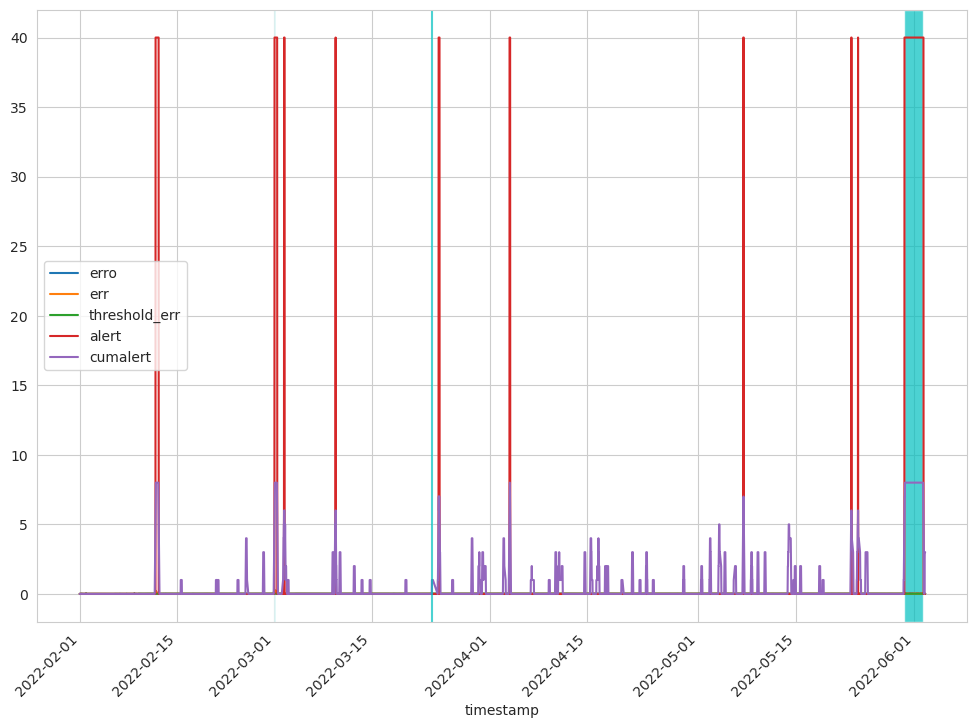

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

err_2.plot(ax=ax)
ax.axvspan('2022-02-28 21:53:00', '2022-03-01 02:00:00', facecolor='c', alpha=0.7)
ax.axvspan('2022-03-23 14:54:00', '2022-03-23 15:24:00', facecolor='c', alpha=0.7)
ax.axvline('2022-03-23 14:54:00', color='c', alpha=0.7)
ax.axvspan('2022-05-30 12:00:00', '2022-06-02 06:18:00', facecolor='c', alpha=0.7)
plt.xticks(rotation=45)

In [46]:
erri = err_2.reset_index()
Xerr = erri[erri['alert'] > 0]
Xset = erri[erri['cumalert'] == 0].sample(len(Xerr))

dsidxerr = list(Xerr.index)
dsixnormal = list(Xset.index)

cl_inputX = np.concatenate((transformedRealX[dsidxerr, :, :], transformedRealX[dsixnormal, :, :]))
cl_inputy = to_categorical(np.concatenate((np.ones(len(Xerr)), np.zeros(len(Xset)))))

In [132]:
fXtrain, fXtest, ftrainy, ftesty = train_test_split(cl_inputX, cl_inputy, shuffle=False)

predicted = model_classifier.predict(fXtrain)
len(predicted)

237

In [133]:
type(predicted)

numpy.ndarray

In [134]:
pd.DataFrame(predicted).describe()

,0,1
count,2.370000e+02,2.370000e+02
mean,1.896325e-01,8.103675e-01
std,3.625112e-01,3.625111e-01
min,0.000000e+00,1.521200e-07
25%,3.706057e-08,9.066128e-01
50%,2.687892e-05,9.999731e-01
75%,9.338725e-02,9.999999e-01
max,9.999998e-01,9.999999e-01


In [105]:
ftrainy[200:210]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [48]:
f1_score(np.argmax(ftrainy, axis=1), np.argmax(predicted, axis=1))

0.8951841359773371

# SHAP

In [83]:
sv_ts_absshap, sv_tr_absshap, shap_values_ts_absshap, shap_values_tr_absshap = calculate_shap_values(
    fXtrain, fXtest,
    ftrainy, ftesty,
    model_classifier,
    stride, window_len,
    shap_version='deep',
    bg_size=1000,
    absshap=True, )

In [64]:
print("test - shap values col1", np.array(sv_ts_absshap).shape)
print("train - shap values col1", np.array(sv_tr_absshap).shape)
print("test - shap values col1+2", np.array(shap_values_ts_absshap).shape)
print("test - shap values col1+2", np.array(shap_values_tr_absshap).shape)

test - shap values col1 (79, 30, 16)
train - shap values col1 (237, 30, 16)
test - shap values col1+2 (2, 79, 30, 16)
test - shap values col1+2 (2, 237, 30, 16)


In [94]:
sv_ts_no_absshap, sv_tr_no_absshap, shap_values_ts_no_absshap, shap_values_tr_no_absshap = calculate_shap_values(
    fXtrain, fXtest, ftrainy, ftesty, model_classifier,
    stride, window_len, shap_version='deep',
    bg_size=1000, absshap=False, )

In [95]:
save_to_pickle(sv_ts_absshap, 'sv_ts_absshap.pkl')
save_to_pickle(sv_tr_absshap, 'sv_tr_absshap.pkl')
save_to_pickle(shap_values_ts_absshap, 'shap_values_ts_absshap.pkl')
save_to_pickle(shap_values_tr_absshap, 'shap_values_tr_absshap.pkl')

save_to_pickle(sv_ts_no_absshap, 'sv_ts_no_absshap.pkl')
save_to_pickle(sv_tr_no_absshap, 'sv_tr_no_absshap.pkl')
save_to_pickle(shap_values_ts_no_absshap, 'shap_values_ts_no_absshap.pkl')
save_to_pickle(shap_values_tr_no_absshap, 'shap_values_tr_no_absshap.pkl')

Saved to shared/metropt/sv_ts_no_absshap.pkl
Saved to shared/metropt/sv_tr_no_absshap.pkl
Saved to shared/metropt/shap_values_ts_no_absshap.pkl
Saved to shared/metropt/shap_values_tr_no_absshap.pkl


In [ ]:
sv_ts_absshap = load_from_pickle("sv_ts_absshap.pkl", directory=DATA_DIRECTORY)
sv_tr_absshap = load_from_pickle("sv_tr_absshap.pkl", directory=DATA_DIRECTORY)

sv_ts_no_absshap = load_from_pickle("sv_ts_no_absshap.pkl", directory=DATA_DIRECTORY)
sv_tr_no_absshap = load_from_pickle("sv_tr_no_absshap.pkl", directory=DATA_DIRECTORY)

In [53]:
# shap_values_ts_v9_seq = load_from_pickle("shap_values_ts_v9_seq.pkl", directory=DATA_DIRECTORY)
# shap_values_tr_v9_seq = load_from_pickle("shap_values_tr_v9_seq.pkl", directory=DATA_DIRECTORY)
# sv_ts_v9_seq = load_from_pickle("sv_ts_absshap_true_v9_seq.pkl", directory=DATA_DIRECTORY)
sv_tr_v9_seq = load_from_pickle("sv_tr_absshap_true_v9_seq.pkl", directory=DATA_DIRECTORY)
# 
# print("sv_ts_absshap shape:", sv_ts_absshap.shape)
# print("sv_tr_absshap shape:", sv_tr_absshap.shape)
# print("sv_ts_v9_seq shape:", sv_ts_v9_seq.shape)  # tylko dla train - don't use
# print("sv_tr_v9_seq shape:", sv_ts_v9_seq.shape)

In [86]:
difference = np.abs(sv_tr_absshap - sv_tr_v9_seq)
total_difference = np.sum(difference)
print("Całkowita różnica:", total_difference)

mse = mean_squared_error(sv_tr_absshap.reshape(-1), sv_tr_v9_seq.reshape(-1))
print("MSE:", mse)

max_difference = np.max(difference)
mean_difference = np.mean(difference)
print("Maksymalna różnica:", max_difference)
print("Średnia różnica:", mean_difference)

Całkowita różnica: 121.17102141523677
MSE: 1.4210713203512505e-05
Maksymalna różnica: 0.13078617222149683
Średnia różnica: 0.0010651461094869617


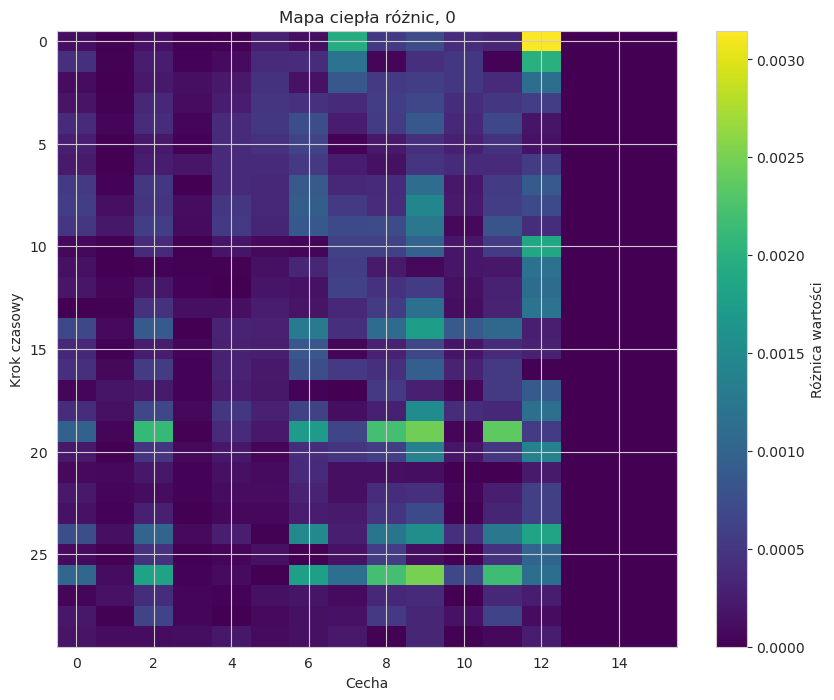

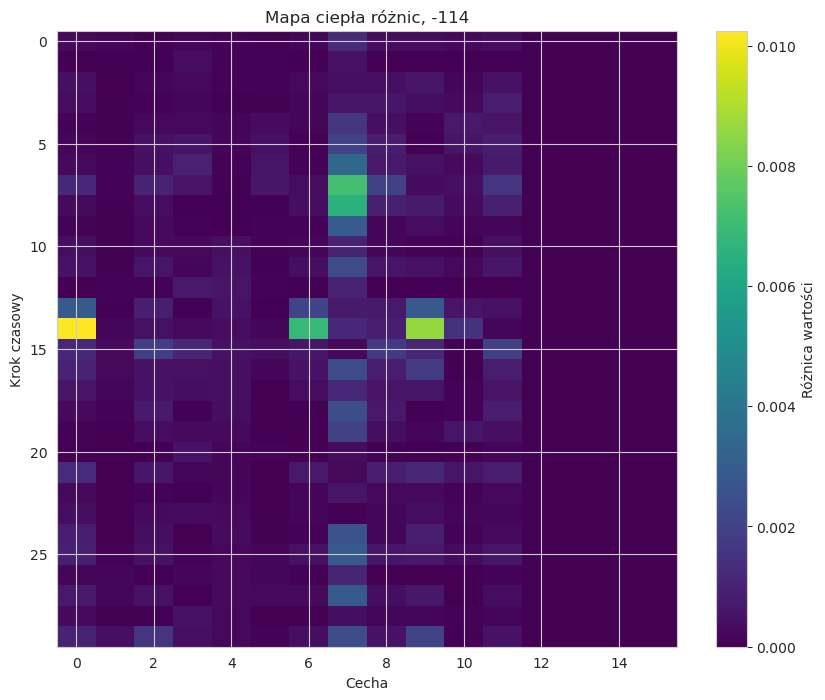

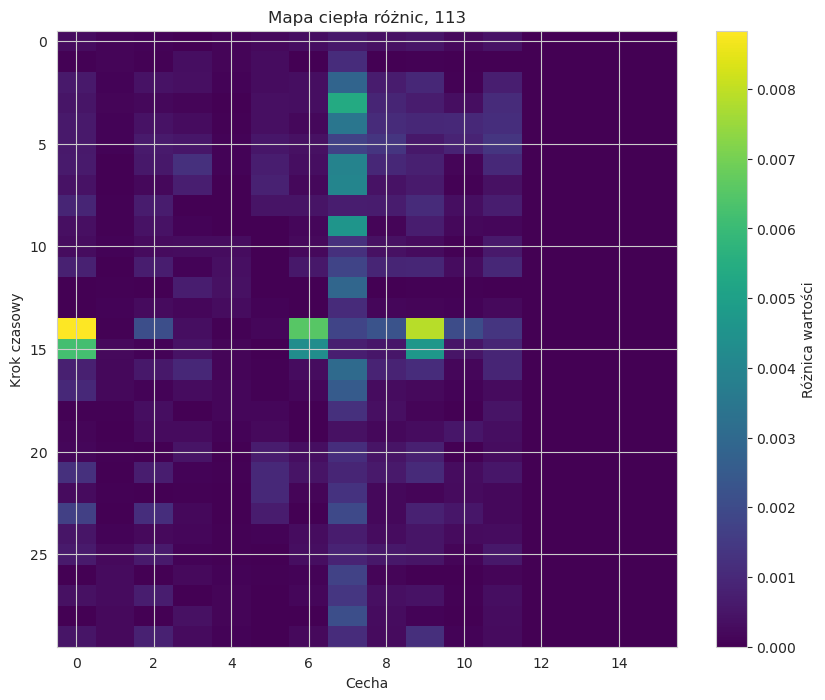

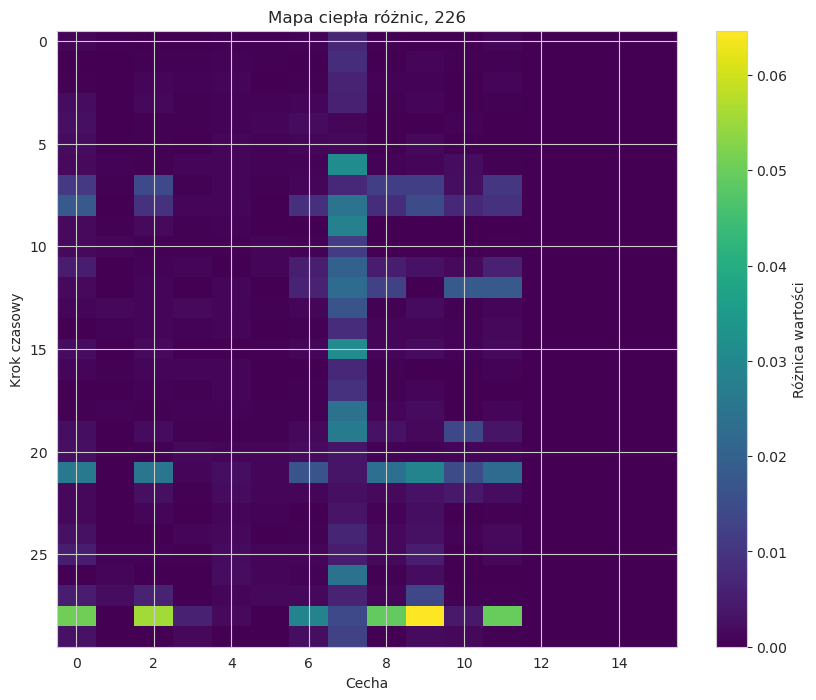

In [87]:
window_indexes = [s // 21 for s in sample_indexs]

for sample_index in window_indexes:
    # Oblicz różnicę dla wybranej próbki
    sample_difference = np.abs(sv_tr_absshap[sample_index] - sv_tr_v9_seq[sample_index])

    # Generuj mapę ciepła różnic
    plt.figure(figsize=(10, 8))
    plt.imshow(sample_difference, cmap='viridis', aspect='auto')
    plt.colorbar(label='Różnica wartości')
    plt.title(f'Mapa ciepła różnic, {sample_index}')
    plt.xlabel('Cecha')
    plt.ylabel('Krok czasowy')
    plt.show()

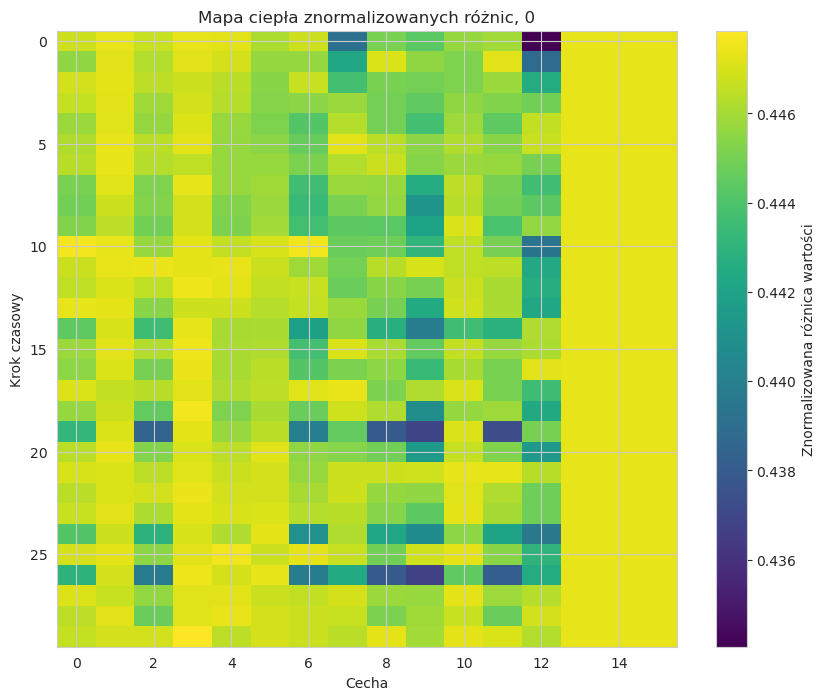

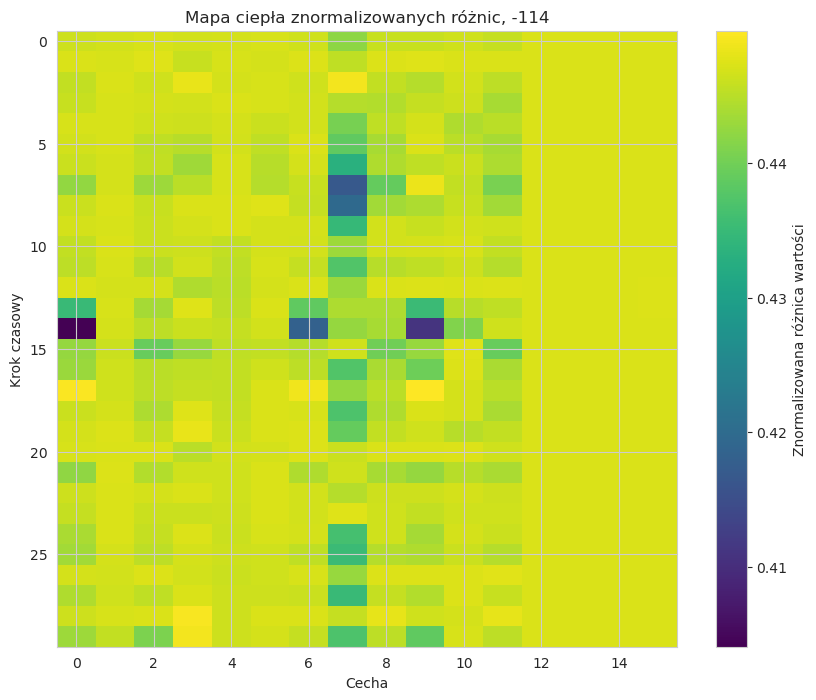

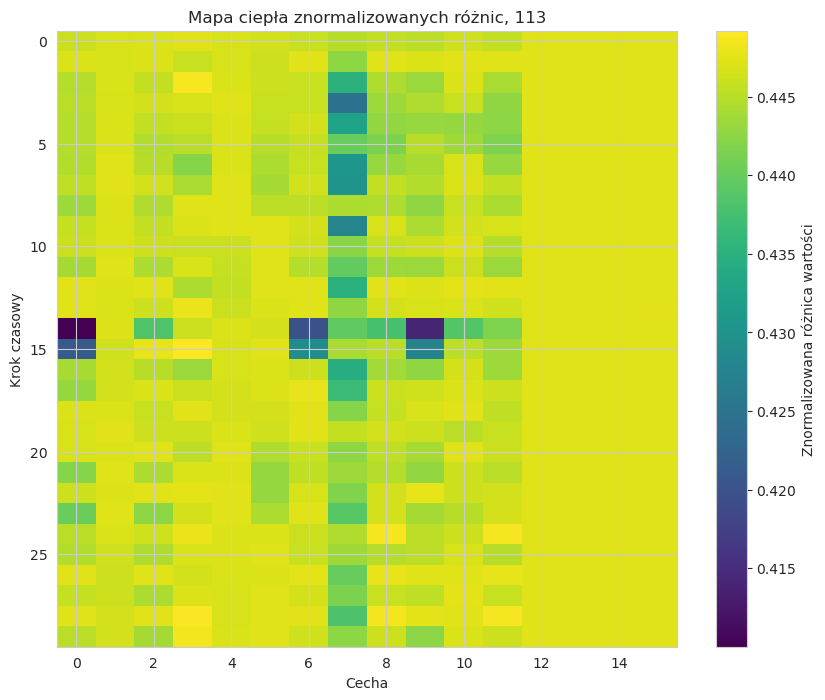

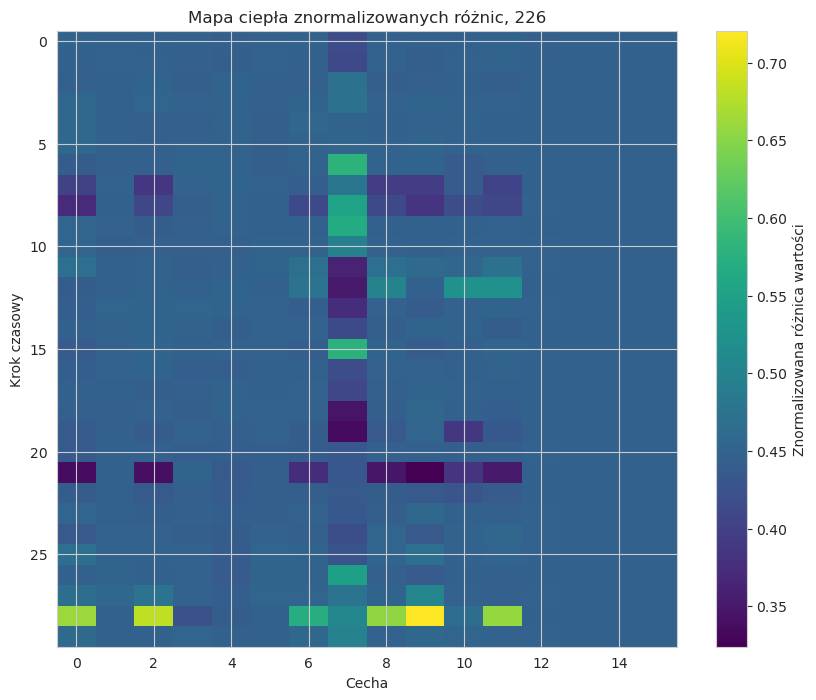

In [88]:
# Obliczanie różnicy między dwoma zestawami danych
difference = sv_tr_absshap - sv_tr_v9_seq

# Normalizacja różnic do zakresu [0, 1]
normalized_difference = (difference - np.min(difference)) / (np.max(difference) - np.min(difference))

# Wybór próbki do wizualizacji
for sample_index in window_indexes:
    # Tworzenie mapy ciepła dla znormalizowanej różnicy
    plt.figure(figsize=(10, 8))
    plt.imshow(normalized_difference[sample_index], cmap='viridis', aspect='auto')
    plt.colorbar(label='Znormalizowana różnica wartości')
    plt.title(f'Mapa ciepła znormalizowanych różnic, {sample_index}')
    plt.xlabel('Cecha')
    plt.ylabel('Krok czasowy')
    plt.show()

# Na podstawie paska kolorów obok mapy ciepła, można zauważyć, że wartości różnic znajdują się w bardzo wąskim zakresie, co sugeruje, że wszystkie znormalizowane różnice między danymi są stosunkowo małe i zbliżone do siebie. Wartości wydają się być z zakresie około -0.434 do -0.424, co jest bardzo niewielką zmiennością. To może wskazywać, że dane w obu zestawach są bardzo podobne do siebie i żadne z danych nie odstaje znacząco od reszty.

In [96]:
sv_tr_absshap[0]

array([[1.51094983e-04, 1.10132643e-05, 2.20593341e-04, 2.52445825e-05,
        8.75202105e-05, 4.11622419e-04, 1.73130586e-04, 2.12609495e-03,
        7.34458633e-04, 8.73292063e-04, 5.16623981e-04, 5.17630856e-04,
        4.62413677e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.48563461e-04, 6.41306933e-06, 3.07112686e-04, 5.87543777e-05,
        1.89757513e-04, 5.49787869e-04, 4.81087186e-04, 1.12672734e-03,
        5.55178327e-05, 4.74921498e-04, 4.57383530e-04, 2.97979432e-05,
        3.12041281e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.91568390e-05, 4.15573234e-06, 2.17825292e-04, 4.03267157e-05,
        3.27655834e-04, 5.73300847e-04, 9.23772768e-05, 8.85357958e-04,
        6.76878629e-04, 6.49010492e-04, 5.54263540e-04, 4.84442803e-04,
        1.98396831e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.09922983e-04, 1.22487488e-05, 6.76308314e-04, 1.49037181e-05,
        3.86348329e-04, 6.07099623e-04, 7.57608194e-04, 5.637

In [97]:
sv_tr_no_absshap[0]

array([[-1.51094940e-04, -1.10132180e-05,  2.20593401e-04,
        -2.52445784e-05,  8.75201537e-05,  4.11622347e-04,
        -1.73130568e-04,  2.12609488e-03,  7.34458668e-04,
         8.73292096e-04,  5.16623866e-04,  5.17630903e-04,
         4.62413641e-03,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-3.48563372e-04,  6.41306312e-06, -3.07112709e-04,
        -5.87543638e-05,  1.89757470e-04,  5.49787828e-04,
        -4.81087136e-04,  1.12672737e-03,  5.55177828e-05,
        -4.74921508e-04,  4.57383436e-04,  2.97979060e-05,
         3.12041244e-03,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 5.91567098e-05, -4.15569062e-06,  2.17825077e-04,
         4.03266968e-05,  3.27655766e-04,  5.73300795e-04,
         9.23769889e-05,  8.85357835e-04,  6.76878275e-04,
         6.49010126e-04,  5.54263515e-04,  4.84442444e-04,
         1.98396822e-03,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 5.09923053e-04,  1.22488092e

# LIME

In [124]:
ftrainy

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

In [122]:
type(fXtrain)  #, fXtest, ftrainy, ftesty
type(ftrainy)
pd.DataFrame(ftesty).describe()

,0,1
count,79.0,79.0
mean,1.0,0.0
std,0.0,0.0
min,1.0,0.0
25%,1.0,0.0
50%,1.0,0.0
75%,1.0,0.0
max,1.0,0.0


In [121]:
pd.DataFrame(ftrainy).describe()

,0,1
count,237.000000,237.000000
mean,0.333333,0.666667
std,0.472402,0.472402
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [115]:
bg_size: int = 25  # num of windows
indexes = np.arange(len(fXtrain))
np.random.shuffle(indexes)
maxid = min(bg_size, len(fXtrain))
_background_data = fXtrain[indexes[:maxid]]
_background_data.shape

(25, 30, 16)

In [127]:
_class_names = ['class_0', 'class_1']

_feature_names = [f'feature_{i}' for i in range(_background_data.shape[2])]
_feature_names

['feature_0',
 'feature_1',
 'feature_2',
 'feature_3',
 'feature_4',
 'feature_5',
 'feature_6',
 'feature_7',
 'feature_8',
 'feature_9',
 'feature_10',
 'feature_11',
 'feature_12',
 'feature_13',
 'feature_14',
 'feature_15']

In [171]:
_flattened_background_data = _background_data.reshape(bg_size, -1)
_flattened_feature_names = [f'timestep_{i // 16}_feature_{i % 16}' for i in range(_flattened_background_data.shape[1])]
len(_flattened_feature_names)

480

In [176]:
_flattened_feature_names

['timestep_0_feature_0',
 'timestep_0_feature_1',
 'timestep_0_feature_2',
 'timestep_0_feature_3',
 'timestep_0_feature_4',
 'timestep_0_feature_5',
 'timestep_0_feature_6',
 'timestep_0_feature_7',
 'timestep_0_feature_8',
 'timestep_0_feature_9',
 'timestep_0_feature_10',
 'timestep_0_feature_11',
 'timestep_0_feature_12',
 'timestep_0_feature_13',
 'timestep_0_feature_14',
 'timestep_0_feature_15',
 'timestep_1_feature_0',
 'timestep_1_feature_1',
 'timestep_1_feature_2',
 'timestep_1_feature_3',
 'timestep_1_feature_4',
 'timestep_1_feature_5',
 'timestep_1_feature_6',
 'timestep_1_feature_7',
 'timestep_1_feature_8',
 'timestep_1_feature_9',
 'timestep_1_feature_10',
 'timestep_1_feature_11',
 'timestep_1_feature_12',
 'timestep_1_feature_13',
 'timestep_1_feature_14',
 'timestep_1_feature_15',
 'timestep_2_feature_0',
 'timestep_2_feature_1',
 'timestep_2_feature_2',
 'timestep_2_feature_3',
 'timestep_2_feature_4',
 'timestep_2_feature_5',
 'timestep_2_feature_6',
 'timestep_2_

In [146]:
class ModelWrapper:
    def __init__(self, model: Any, timesteps: int, features: int):
        self.model = model
        self.timesteps = timesteps
        self.features = features

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        # Reshape flattened data back to (n_windows, timesteps, features)
        if len(X.shape) == 1:  # Single sample
            n_samples = 1
            X_reshaped = X.reshape(n_samples, self.timesteps, self.features)
        else:  # Batch of samples
            # Calculate the number of samples by dividing the flat array's length by (timesteps * features)
            n_samples = X.shape[0]
            # Reshape the flat array to (n_samples, timesteps, features)
            X_reshaped = X.reshape(n_samples, self.timesteps, self.features)

        # Make predictions with the reshaped data
        preds = self.model.predict(X_reshaped)
        if preds.shape[1] == 1:  # Binary classification
            # For binary classification, return the complement probability for the negative class
            return np.hstack([1 - preds, preds])
        else:  # Multiclass classification
            return preds


model_wrapper = ModelWrapper(model_classifier, timesteps=30, features=16)

single_prediction = model_wrapper.predict_proba(_flattened_background_data[10])
print('single_prediction', single_prediction)

batch_prediction = model_wrapper.predict_proba(_flattened_background_data)
print('batch_prediction', batch_prediction[9:])

single_prediction [[1.7074220e-06 9.9999833e-01]]
batch_prediction [[2.4160564e-16 9.9999994e-01]
 [1.7074202e-06 9.9999827e-01]
 [6.0326443e-08 9.9999982e-01]
 [1.7494430e-06 9.9999815e-01]
 [9.9955857e-01 4.4146815e-04]
 [1.8410996e-07 9.9999970e-01]
 [3.0296021e-03 9.9697047e-01]
 [4.7260078e-04 9.9952745e-01]
 [1.3404017e-10 9.9999994e-01]
 [1.1315924e-01 8.8684076e-01]
 [9.5310788e-05 9.9990457e-01]
 [9.9947232e-01 5.2759680e-04]
 [4.2314527e-06 9.9999577e-01]
 [6.2346946e-02 9.3765301e-01]
 [7.0592052e-01 2.9407948e-01]
 [5.7232285e-01 4.2767712e-01]]


In [155]:
lime_explainer = LimeTabularExplainer(_flattened_background_data,
                                      feature_names=_flattened_feature_names,
                                      class_names=_class_names,
                                      mode='classification')

In [154]:
_instance = fXtrain[0]
_flattened_instance = _instance.reshape(1, -1)[0]
explanation = lime_explainer.explain_instance(_flattened_instance, model_wrapper.predict_proba,
                                              num_features=len(_flattened_feature_names))
lime_importance = np.array([explanation.local_exp[1][i][1] for i in range(len(_flattened_feature_names))])
original_shape_importance = lime_importance.reshape((30, 16))
original_shape_importance

array([[-1.60695559e-03,  1.51824522e-03,  1.46782118e-03,
        -1.42731840e-03,  1.38070461e-03,  1.37932833e-03,
         1.23315982e-03, -1.19163305e-03, -1.18325481e-03,
        -1.16936223e-03,  1.14708278e-03, -1.13660899e-03,
        -1.12352671e-03,  1.11428214e-03, -1.10113142e-03,
         1.08111134e-03],
       [ 1.07881932e-03, -1.05183674e-03, -1.04329468e-03,
        -1.03962331e-03, -1.01938225e-03, -1.00618967e-03,
        -9.97822213e-04, -9.76069508e-04, -9.26458440e-04,
         9.24555160e-04, -9.06077323e-04, -9.00049108e-04,
         8.97817107e-04, -8.90169336e-04, -8.87513167e-04,
         8.74125254e-04],
       [-8.65862194e-04,  8.59144656e-04,  8.48309513e-04,
         8.47503705e-04,  8.46590613e-04, -8.42953083e-04,
         8.32774961e-04, -8.25730674e-04, -8.17252757e-04,
        -7.87758688e-04, -7.87026970e-04, -7.50306616e-04,
        -7.46956707e-04, -7.35341519e-04, -7.29910357e-04,
        -7.21228644e-04],
       [ 7.03822562e-04, -7.01532177e

In [162]:
fXtrain[2:9, :, :].shape

(7, 30, 16)

In [175]:
def compute_single_lime_explanation(index, instance, model_wrapper, explainer, num_features, timesteps):
    """
    Compute LIME explanation for a single instance and reshape its importance.

    :param index: Index of the instance for identification.
    :param instance: The instance to explain, expected to be in the original shape (timesteps, features).
    :param model_wrapper: The model wrapper with a predict_proba function.
    :param explainer: The LIME TabularExplainer object.
    :param num_features: The total number of features (timesteps * features per timestep).
    :param timesteps: The number of timesteps in the instance data.
    :return: A tuple of the index and the reshaped LIME importance.
    """
    # Flatten the instance for LIME
    flattened_instance = instance.reshape(1, -1)[0]

    # Get the LIME explanation for the flattened instance
    explanation = explainer.explain_instance(
        flattened_instance, model_wrapper.predict_proba, num_features=num_features * timesteps)

    # Get the LIME importance for the features and reshape it
    # print(explanation.local_exp)
    lime_importance = np.array([explanation.local_exp[1][i][1] for i in range(num_features * timesteps)])
    reshaped_importance = lime_importance.reshape((timesteps, num_features))

    return index, reshaped_importance


def compute_lime_explanation(instances, model_wrapper, explainer, num_features, timesteps, num_cores):
    """
    Explain multiple instances using LIME and reshape their importance values.

    :param instances: The instances to explain, expected to be in the original shape (samples, timesteps, features).
    :param model_wrapper: The model wrapper with a predict_proba function.
    :param explainer: The LIME TabularExplainer object.
    :param num_features: The number of features per timestep in the instance data.
    :param timesteps: The number of timesteps in the instance data.
    :param num_cores: The number of CPU cores to use for parallel computation.
    :return: A 3D array with explanations reshaped to original instance shapes (samples, timesteps, features).
    """
    # # Use joblib's Parallel and delayed to compute explanations in parallel
    # results = Parallel(n_jobs=num_cores)(delayed(compute_single_lime_explanation)(
    #     index, instance, explainer, model_wrapper, num_features, timesteps
    # ) for index, instance in enumerate(instances))
    # 
    # # Order results by instance index and extract the importance arrays
    # ordered_results = [x[1] for x in sorted(results, key=lambda x: x[0])]
    ordered_results = []
    for index, instance in enumerate(instances):
        _, reshaped_importance = compute_single_lime_explanation(
            index, instance, model_wrapper, explainer, num_features, timesteps)
        ordered_results.append(reshaped_importance)

    # Combine the explanations into a single array
    combined_explanations = np.array(ordered_results)
    return combined_explanations


lime_explanation_fXtrain_2_9 = compute_lime_explanation(fXtrain[2:9, :, :], model_wrapper, lime_explainer, 16, 30, 10)
lime_explanation_fXtrain_2_9

array([[[-0.00153256,  0.00150399, -0.00149562, ...,  0.00100433,
         -0.00099964, -0.00099466],
        [ 0.00094553, -0.00092814, -0.00092153, ...,  0.00077697,
          0.00077024, -0.00075059],
        [-0.00074946, -0.00074826, -0.00074824, ..., -0.00066291,
         -0.00065117,  0.00064036],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[-0.0014862 , -0.00136985,  0.00135881, ...,  0.00105914,
          0.0010577 ,  0.00104057],
        [ 0.00099796, -0.00095391,  0.00093014, ..., -0.0007728 ,
         -0.00076805, -0.00076659],
        [-0.00076097, -0.00072029,  0.00071885, ..., -0.00064582,
          0.00063974,  0.00063124],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  

In [ ]:
def calculate_explanations_values(fXtrain: np.ndarray,
                                  fXtest: np.ndarray,
                                  ftrainy: np.ndarray,
                                  ftesty: np.ndarray,
                                  model_classifier: Any,
                                  explainer_type: str,
                                  background_data,
                                  num_features: int,
                                  timesteps: int,
                                  absshap: bool = True,
                                  ) -> Tuple[
    Optional[np.ndarray], Optional[np.ndarray], Optional[np.ndarray], Optional[np.ndarray]]:
    """
    Calculates SHAP values for training and testing datasets using either DeepExplainer or SlidingWindowSHAP.
    
    :param fXtrain: Training features.
    :param fXtest: Testing features.
    :param ftrainy: Training labels.
    :param ftesty: Testing labels.
    :param model_classifier: The model to explain.
    :param explainer_type: 
    :param background_data: 
    :param num_features: .
    :param timesteps: .
    :param absshap: Whether to use absolute SHAP values, only for DeepExplainer.
    :return: Tuple of SHAP values for training and testing datasets.
    """
    sv_ts, sv_tr, shap_values_ts, shap_values_tr = None, None, None, None

    if explainer_type == 'SHAP':
        # Handle deep SHAP
        explainer = shap.DeepExplainer(model_classifier, background_data)
        shap_values_ts = explainer.shap_values(fXtest, check_additivity=False)
        shap_values_tr = explainer.shap_values(fXtrain, check_additivity=False)
    elif explainer_type == 'LIME':
        model_wrapper = ModelWrapper(model_classifier, timesteps=30, features=16)

        flattened_background_data = background_data.reshape(bg_size, -1)
        flattened_feature_names = [f'timestep_{i // num_features}_feature_{i % num_features}' for i in
                                   range(flattened_background_data.shape[1])]
        explainer = LimeTabularExplainer(flattened_background_data,
                                         feature_names=flattened_feature_names,
                                         class_names=_class_names,
                                         mode='classification')
        shap_values_ts = compute_lime_explanation(fXtest, model_wrapper, explainer, num_features, timesteps, -1)
        shap_values_tr = compute_lime_explanation(fXtrain, model_wrapper, explainer, num_features, timesteps, -1)

    if absshap:
        sv_ts = abs(np.array(shap_values_ts)).mean(axis=0)
        sv_tr = abs(np.array(shap_values_tr)).mean(axis=0)
    else:
        indexer_ts = np.argmax(model_classifier.predict(fXtest), axis=1)
        sv_ts = [shap_values_ts[indexer_ts[i]][i, :] for i in range(len(fXtest))]
        sv_ts = np.concatenate(sv_ts).reshape((-1, timesteps, num_features))

        indexer_tr = np.argmax(model_classifier.predict(fXtrain), axis=1)
        sv_tr = [shap_values_tr[indexer_tr[i]][i, :] for i in range(len(fXtrain))]
        sv_tr = np.concatenate(sv_tr).reshape((-1, timesteps, num_features))

    return sv_ts, sv_tr, shap_values_ts, shap_values_tr


lv_ts_no_absshap, lv_tr_no_absshap, lime_values_ts_no_absshap, lime_values_tr_no_absshap = calculate_explanations_values(
    fXtrain, fXtest, ftrainy, ftesty, model_classifier,
    explainer_type='LIME', background_data=_background_data,
    num_features=16, timesteps=30, absshap=False, )

In [ ]:
lv_ts_absshap, lv_tr_absshap, lime_values_ts_absshap, lime_values_tr_absshap = calculate_explanations_values(
    fXtrain, fXtest, ftrainy, ftesty, model_classifier,
    explainer_type='LIME', background_data=_background_data,
    num_features=16, timesteps=30, absshap=True, )

In [ ]:
save_to_pickle(lv_ts_no_absshap, 'lv_ts_no_absshap.pkl')
save_to_pickle(lv_tr_no_absshap, 'lv_tr_no_absshap.pkl')
save_to_pickle(lime_values_ts_no_absshap, 'lime_values_ts_no_absshap.pkl')
save_to_pickle(lime_values_tr_no_absshap, 'lime_values_tr_no_absshap.pkl')

save_to_pickle(lv_ts_absshap, 'lv_ts_absshap.pkl')
save_to_pickle(lv_tr_absshap, 'lv_tr_absshap.pkl')
save_to_pickle(lime_values_ts_absshap, 'lime_values_ts_absshap.pkl')
save_to_pickle(lime_values_tr_absshap, 'lime_values_tr_absshap.pkl')